In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
car=pd.read_csv('cars-dataset.csv')
car.shape

(398, 8)

In [26]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [27]:
#hp is a numeric column, but has object data type, which means it contains some non numeric values
#Finding the non numeric values in hp column

mask = car.hp.map(lambda x: not str(x).isdigit())
car[mask]

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98.0,?,2046,19.0,71,25.0
126,ford maverick,6,200.0,?,2875,17.0,74,21.0
330,renault lecar deluxe,4,85.0,?,1835,17.3,80,40.9
336,ford mustang cobra,4,140.0,?,2905,14.3,80,23.6
354,renault 18i,4,100.0,?,2320,15.8,81,34.5
374,amc concord dl,4,151.0,?,3035,20.5,82,23.0


In [28]:
#Removing non numeric values from hp column and converting it to int datatype

car = car[~ mask]
car.hp = car.hp.map(int)
car = car.reset_index(drop=True)
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
car name    392 non-null object
cyl         392 non-null int64
disp        392 non-null float64
hp          392 non-null int64
wt          392 non-null int64
acc         392 non-null float64
yr          392 non-null int64
mpg         392 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 24.6+ KB


In [29]:
len(car["car name"].unique().tolist())

301

In [30]:
#Dropping car name column, as it has high cardinality and grouping is not possible

car.drop(columns = "car name", inplace = True)
car.head(3)

,cyl,disp,hp,wt,acc,yr,mpg
0,8,307.0,130,3504,12.0,70,18.0
1,8,350.0,165,3693,11.5,70,15.0
2,8,318.0,150,3436,11.0,70,18.0


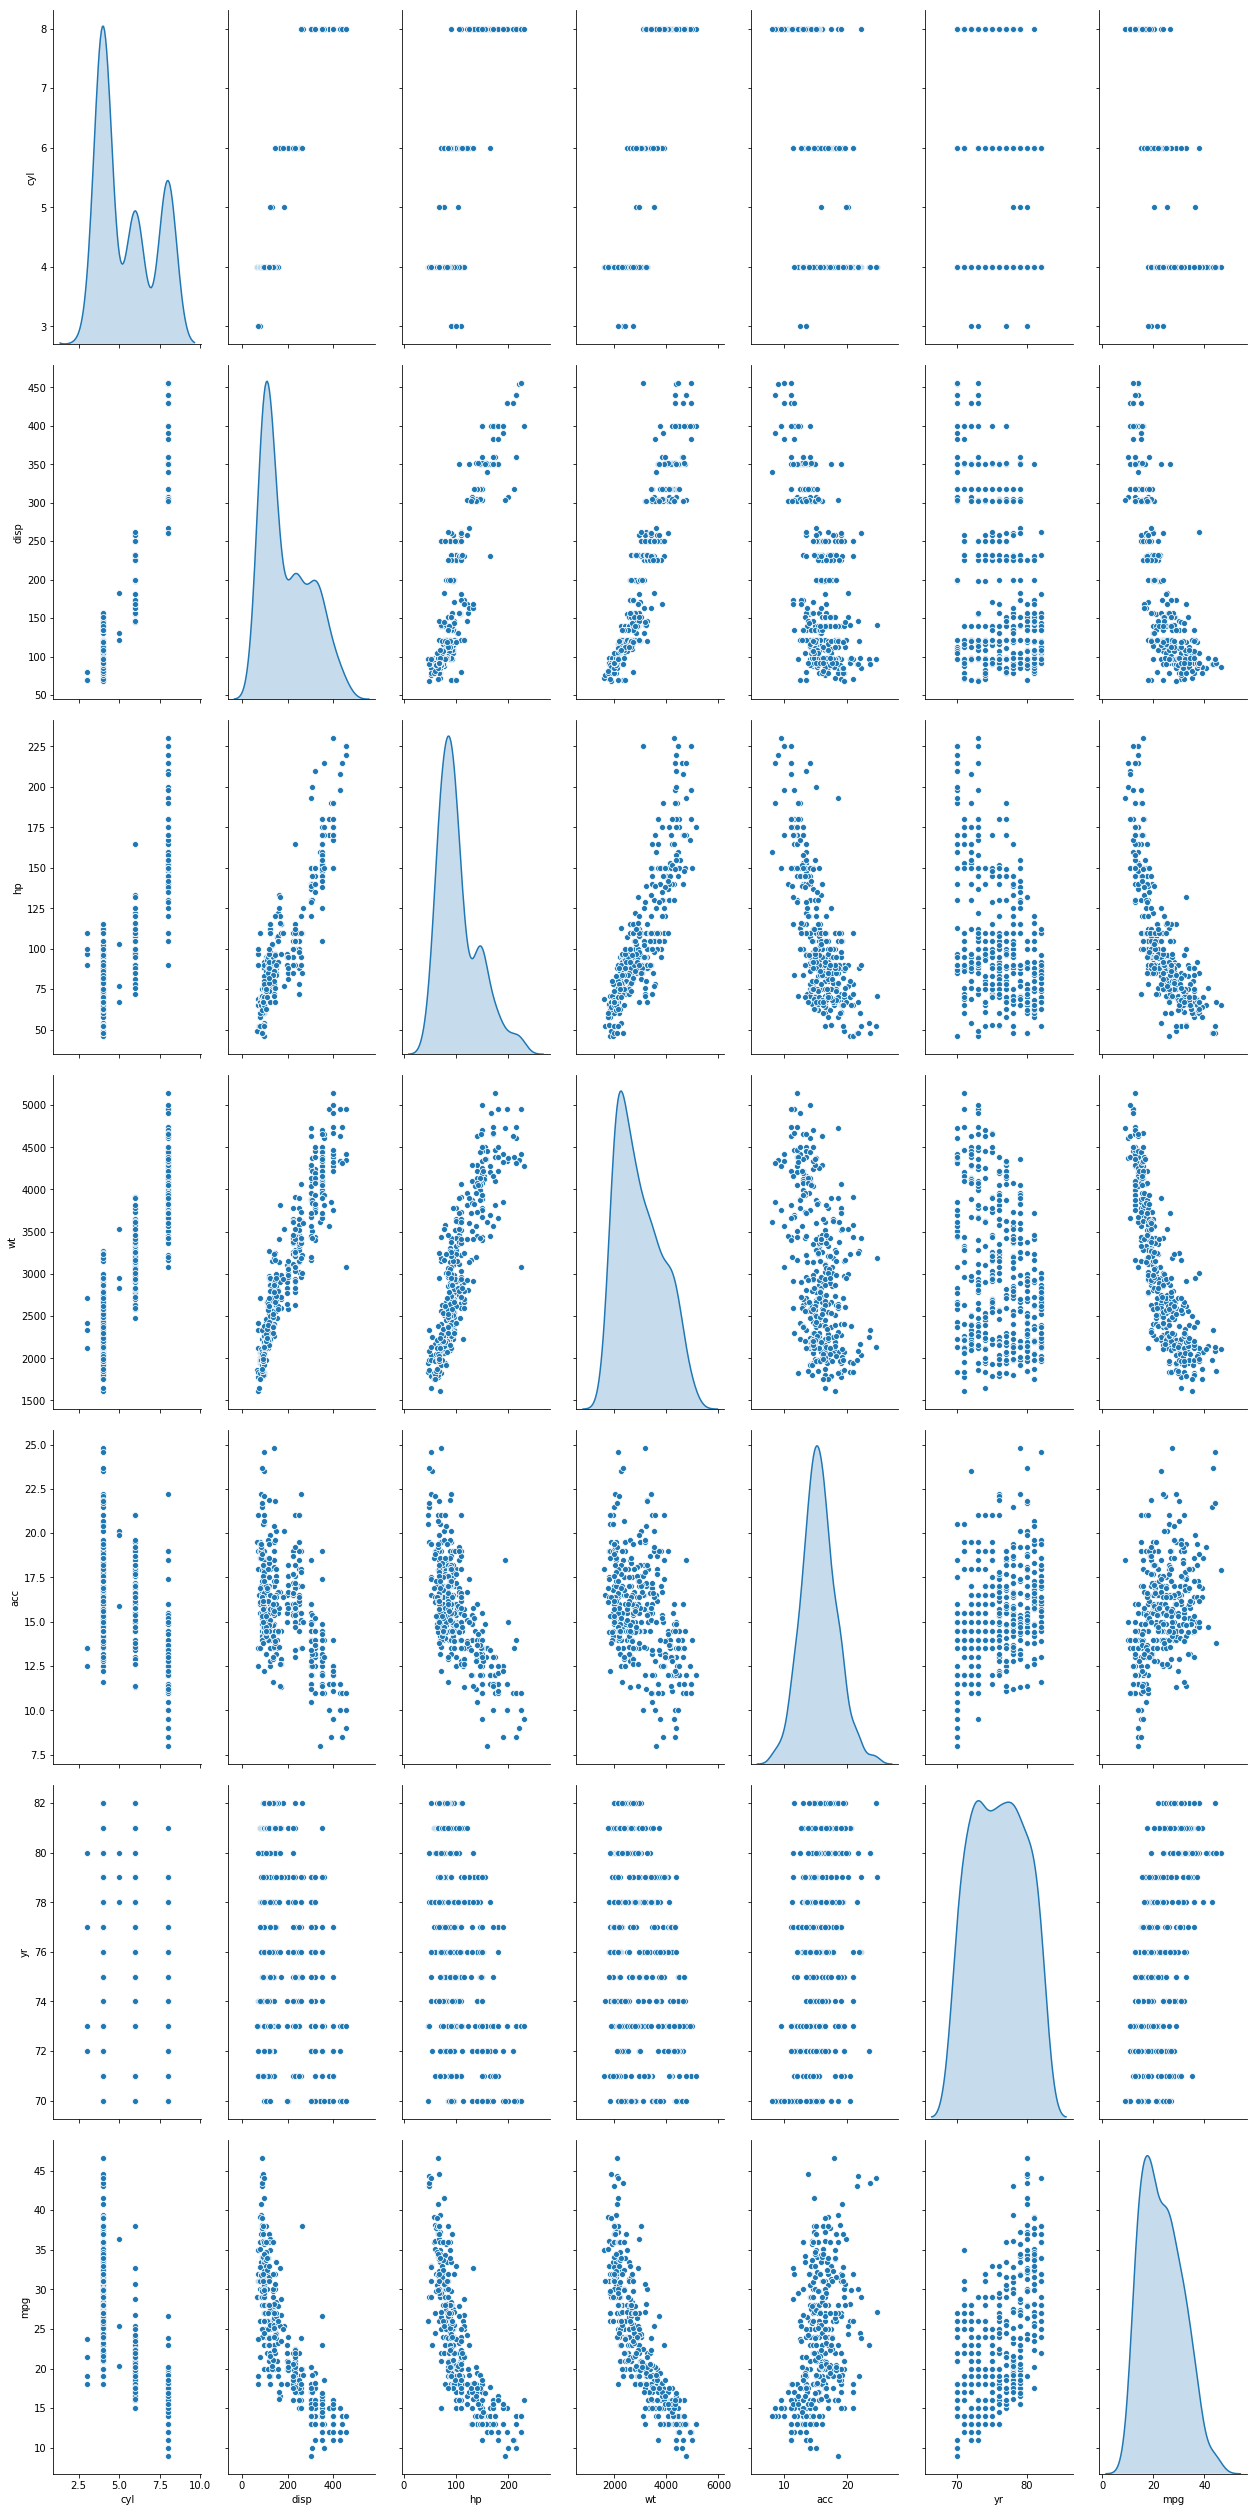

In [31]:
sns.pairplot(car, height = 5, aspect=0.5 , diag_kind='kde')

# The Gaussian curves in the plot indicates that there could be a minimum of 3 clusters in the given dataset

In [32]:
from scipy.stats import zscore

#performing the scaling operation

car1 = car.apply(zscore) 
car1.head(2)

,cyl,disp,hp,wt,acc,yr,mpg
0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.698638
1,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-1.083498


In [33]:
distortion =[]
from sklearn.cluster import KMeans
from scipy.spatial import distance
for k in range(1, 10):
    model = KMeans(n_clusters=k).fit(car1)
    distortion.append(sum(np.min(distance.cdist(car1, model.cluster_centers_,'euclidean'), axis=1))/(car1.shape[0]))

In [34]:
#Mean distortions for 1 to 9 clusters
distortion

[2.4599540277021017,
 1.6934623956814503,
 1.4306047581142727,
 1.2510807241951143,
 1.1917371978635267,
 1.1335931240892012,
 1.0820016566977768,
 1.0332251718110026,
 0.9958435031200547]

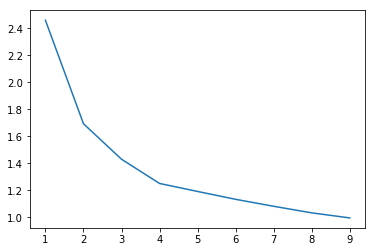

In [35]:
#Elbow curve
plt.plot(range(1,10), distortion)

In [36]:
#From the elbow curve, we can choose 3 as the value for k

model2=KMeans(n_clusters=3)
model2.fit(car1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [37]:
#Creating labels for each observation
lab = model2.labels_

#Appending labels of each observation to the dataframe used for modelling
car1["labels"] = lab 
car1.head(3)

,cyl,disp,hp,wt,acc,yr,mpg,labels
0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.698638,0
1,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-1.083498,0
2,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,-0.698638,0


In [38]:
car["labels"] = lab
car.head(3)

,cyl,disp,hp,wt,acc,yr,mpg,labels
0,8,307.0,130,3504,12.0,70,18.0,0
1,8,350.0,165,3693,11.5,70,15.0,0
2,8,318.0,150,3436,11.0,70,18.0,0


In [39]:
#Identifying the clusters

car1["labels"].unique()

array([0, 1, 2], dtype=int64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013D33320>,
      dtype=object)

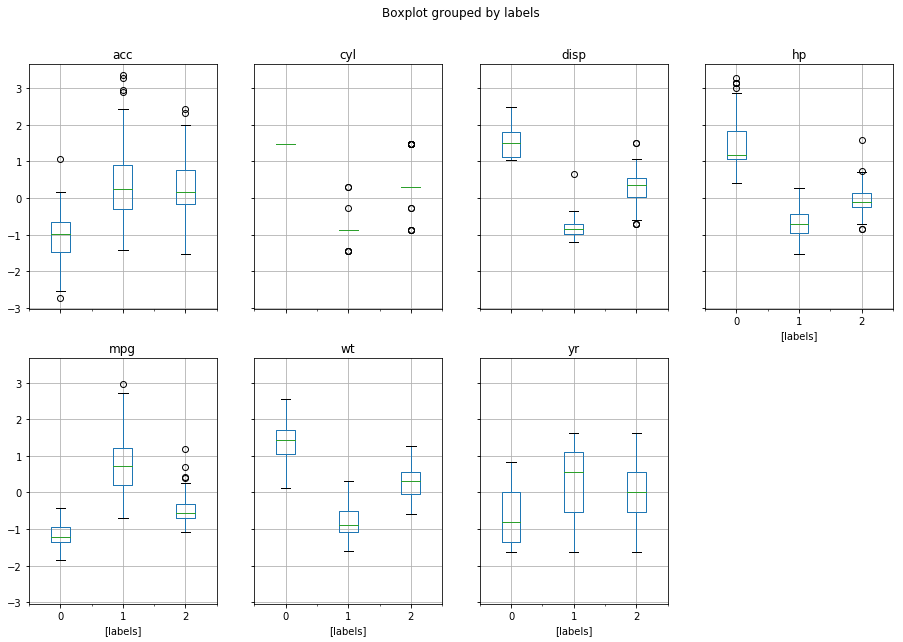

In [40]:
car1.boxplot(by = 'labels', layout=(2,4), figsize=(15, 10))

Inference from the box plots

Group 0 (cluster 1) - heavy weight is clearly the 'super car' segment with larger number of cylinders, highest displacement, horsepower & weight and thereby the best acceleration (least in seconds) & poorest fuel economy. It is also evident that the dataset doesnt contain observations about Group 2 (cluster 3) in the later years of the observation period. Group 1 (cluster 2) - medium weight contains the in-between models. They have higher horse power than Group 1(cluster 2) and thus better acceleration times. The higher power comes at the cost of mileage as they are heavier possibly due to the larger number of cylinders when compared with Group 1(cluster 2). These models too have not been represented as well as the Group 1 models during the later part of the observation period. Group 2 (cluster 3) - light weight contains the most feul efficient models in the given dataset. However these models are considerably lighter than those in the other groups and are the least powerful among the three groups. The models in this group could be ideal for city driving with moderate to heavy traffic and might be unsuitable for highways or expressways owing to the larger acceleration times & lower weights.

In [43]:
#Separating the Clusters

#Cluster1 - Heavy Weight

clust1_df = car1[car["labels"] == 0]
print(clust1_df.shape)


#Cluster2 - Medium Weight

clust2_df = car1[car["labels"] == 1]
print(clust2_df.shape)

#Cluster3 - Light Weight

clust3_df = car1[car["labels"] == 2]
print(clust3_df.shape)

(95, 8)
(202, 8)
(95, 8)


In [44]:
#Linear Regression model on different clusters separately

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [50]:
#Modelling Cluster 1 - Heavy weight

X1 = clust1_df.drop(columns = ["mpg", "labels"])
y1 = clust1_df[['mpg']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)
print(X1_train.shape)
print(X1_test.shape)
linreg1 = LinearRegression()
linreg1.fit(X1_train, y1_train)
print(linreg1.score(X1_train, y1_train))
print(linreg1.score(X1_test, y1_test))

(76, 6)
(19, 6)
0.6475990659856756
0.16786889072136035


In [51]:
#Modelling Cluster 2 - Medium weight

X2 = clust2_df.drop(columns = ["mpg", "labels"])
y2 = clust2_df[['mpg']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1)
print(X2_train.shape)
print(X2_test.shape)
linreg2 = LinearRegression()
linreg2.fit(X2_train, y2_train)
print(linreg2.score(X2_train, y2_train))
print(linreg2.score(X2_test, y2_test))

(161, 6)
(41, 6)
0.6939868445097135
0.5923797943034841


In [52]:
#Modelling Cluster 3 - Light weight

X3 = clust3_df.drop(columns = ["mpg", "labels"])
y3 = clust3_df[['mpg']]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=1)
print(X3_train.shape)
print(X3_test.shape)
linreg3 = LinearRegression()
linreg3.fit(X3_train, y3_train)
print(linreg3.score(X3_train, y3_train))
print(linreg3.score(X3_test, y3_test))

(76, 6)
(19, 6)
0.49101853034069776
0.33629928877942983


In [53]:
#Print the coefficients of the models individually

#Storing the coefficients of the 3 models

coeff_df = pd.DataFrame(columns = ["coefficient", "cluster 1 MW", "cluster 2 LW", "cluster 3 HW"])
coeff_df["coefficient"] = X1_train.columns

for idx, col_name in enumerate(X1_train.columns):
    coeff_df["cluster 1 MW"][idx] = linreg1.coef_[0][idx]

for idx, col_name in enumerate(X2_train.columns):
    coeff_df["cluster 2 LW"][idx] = linreg2.coef_[0][idx]

for idx, col_name in enumerate(X3_train.columns):
    coeff_df["cluster 3 HW"][idx] = linreg3.coef_[0][idx]

print (coeff_df)

  coefficient cluster 1 MW cluster 2 LW cluster 3 HW
0         cyl            0      1.95383     0.186669
1        disp    0.0278009    -0.914884    -0.157456
2          hp    -0.146218    -0.257818    -0.185153
3          wt    -0.168406    -0.488432    -0.338569
4         acc    -0.160302  -0.00322612    -0.118354
5          yr     0.180743      0.41814     0.244455
